# Emotion Recognition Using Wav2Vec 2.0

**Wav2Vec 2.0** is a pretrained model for Automatic Speech Recognition (ASR) and was released in [September 2020](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) by Alexei Baevski, Michael Auli, and Alex Conneau.  Soon after the superior performance of Wav2Vec2 was demonstrated on the English ASR dataset LibriSpeech, *Facebook AI* presented XLSR-Wav2Vec2 (click [here](https://arxiv.org/abs/2006.13979)). XLSR stands for *cross-lingual  speech representations* and refers to XLSR-Wav2Vec2`s ability to learn speech representations that are useful across multiple languages.

Similar to Wav2Vec2, XLSR-Wav2Vec2 learns powerful speech representations from hundreds of thousands of hours of speech in more than 50 languages of unlabeled speech. Similar, to [BERT's masked language modeling](http://jalammar.github.io/illustrated-bert/), the model learns contextualized speech representations by randomly masking feature vectors before passing them to a transformer network.

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/xlsr_wav2vec2.png)

The authors show for the first time that massively pretraining an ASR model on cross-lingual unlabeled speech data, followed by language-specific fine-tuning on very little labeled data achieves state-of-the-art results. See Table 1-5 of the official [paper](https://arxiv.org/pdf/2006.13979.pdf).

During fine-tuning week hosted by HuggingFace, more than 300 people participated in tuning XLSR-Wav2Vec2's pretrained on low-resources ASR dataset for more than 50 languages. This model is fine-tuned using [Connectionist Temporal Classification](https://distill.pub/2017/ctc/) (CTC), an algorithm used to train neural networks for sequence-to-sequence problems and mainly in Automatic Speech Recognition and handwriting recognition. Follow this [notebook](https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Fine_Tune_XLSR_Wav2Vec2_on_Turkish_ASR_with_%F0%9F%A4%97_Transformers.ipynb#scrollTo=Gx9OdDYrCtQ1) for more information about XLSR-Wav2Vec2 fine-tuning.

This model was shown significant results in many low-resources languages. You can see the [competition board](https://paperswithcode.com/dataset/common-voice) or even testing the models from the [HuggingFace hub](https://huggingface.co/models?filter=xlsr-fine-tuning-week).


In this notebook, we will go through how to use this model to recognize the emotional aspects of speech in a language (or even as a general view using for every classification problem). Before going any further, we need to install some handy packages and define some enviroment values.

### Installing the dependencies and Initial setup

The %%capture magic command in a Jupyter Notebook is used to capture the output of a cell, including standard output (stdout) and standard error (stderr), without displaying it in the notebook. This can be particularly useful when you want to run a cell that produces a lot of output or when you want to suppress output that you don't need to see.

In [1]:
%%capture
# Install necessary packages for audio processing and emotion recognition
!pip install jiwer torchaudio librosa

# Install Hugging Face datasets and transformers for model usage
!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git

# Monitor the training process
# !pip install wandb

In [2]:
# Setting environment variables for the notebook
# LC_ALL and LANG are set to C.UTF-8 to ensure consistent character encoding
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8

# Setting cache directories for transformers and datasets
%env TRANSFORMERS_CACHE=.
%env HF_DATASETS_CACHE=.

# Setting CUDA_LAUNCH_BLOCKING to 1 to enable synchronous CUDA kernel launches
%env CUDA_LAUNCH_BLOCKING=1

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8
env: TRANSFORMERS_CACHE=.
env: HF_DATASETS_CACHE=.
env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
# # Uncomment this part if you want to setup your wandb project

# %env WANDB_WATCH=all
# %env WANDB_LOG_MODEL=1
# %env WANDB_PROJECT=YOUR_PROJECT_NAME
# !wandb login YOUR_API_KEY --relogin

## Prepare Data

CREMA-D (Crowd Sourced Emotional Multimodal Actors Dataset)
License: Open Database License, https://opendatacommons.org/licenses/odbl/1-0/

- Number of Dataset: 7442
- 48 male and 43 female actors between the ages of 20 and 74.
- A variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified).
- Emotion 6 Classes: Anger, Disgust, Fear, Happy, Neutral, Sad
- In addition, it contains Gender, Age and Emotion Level features.

In [1]:
# Importing necessary libraries for data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing Path for file path manipulation and tqdm for progress bars
from pathlib import Path
from tqdm import tqdm

# Importing torchaudio for audio processing and sklearn for model selection
import torchaudio
from sklearn.model_selection import train_test_split
import librosa
import IPython.display as ipd
from datasets import load_dataset

# Importing os and sys for system operations and system-specific parameters
import os
import sys
from rich import print

c:\Users\yuvraj.s_maxval\Desktop\F_Projects\VocalEmotion-AI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Checking the naming convention of files

In [2]:
# Initialize count of files with correct naming format
count = 0
root_dir = os.path.dirname("Audio_Files/")

# Check each file in the directory
for file in os.listdir(root_dir):
    file_path = os.path.join(root_dir, file)
    if os.path.exists(file_path):
        # Check if file name has correct format (4 parts separated by '_') and ends with .wav extension
        if len(file.split('_')) != 4 or not file.endswith('.wav'):
            print(file)  # Print file name if format is incorrect or does not end with .wav
        else:
            count += 1

# Printing result
if count != 7442:
    print("Some files have wrong naming format")
else:
    print("All files have correct naming format")

All files have correct naming format

Now since all the files have consistent naming convention so we will now create a dataframe having 2 features, file_path and label

In [3]:
# Initializing a dictionary
data = []

# Create a dictionary mapping labels to their short forms
label_mapping = {
    "ANG": "Anger",
    "DIS": "Disgust",
    "FEA": "Fear",
    "HAP": "Happy",
    "NEU": "Neutral",
    "SAD": "Sad"
}

root_dir = "Audio_Files/"
for file in os.listdir(root_dir):
    file_path = os.path.join(root_dir,file)

    # Getting the label
    label = file.split('_')[2]
    label_short_form = label_mapping.get(label, "UNK")
    
    # Check if the file is broken or non-existent
    try:
        # Load the file with torchaudio
        s = torchaudio.load(file_path)
        # Add the file path, label and emotion to the data dictionary
        data.append({"file_path": file_path, "label": label_short_form, "emotion": label})
    except Exception as e:
        # Print the error if the file is broken or non-existent
        print(f"Error loading file {file_path}: {e}")
        pass

print("Dataframe creation completed")
df = pd.DataFrame(data)

Dataframe creation completed

In [4]:
# Checking first 5 rows of the dataframe
df.head(5)

,file_path,label,emotion
0,Audio_Files/1001_DFA_ANG_XX.wav,Anger,ANG
1,Audio_Files/1001_DFA_DIS_XX.wav,Disgust,DIS
2,Audio_Files/1001_DFA_FEA_XX.wav,Fear,FEA
3,Audio_Files/1001_DFA_HAP_XX.wav,Happy,HAP
4,Audio_Files/1001_DFA_NEU_XX.wav,Neutral,NEU


In [5]:
print(f"File count Before: {len(df)}")

# Add a 'status' column to check if the file path exists
df["status"] = df["file_path"].apply(lambda path: True if os.path.exists(path) else None)

# Drop rows where 'status' is None, indicating non-existent paths
df = df.dropna(subset=["file_path"])

# Remove the 'status' column as it's no longer needed
df = df.drop("status", axis=1) 

# Print the file count after filtering out non-existent paths
print(f"File counter after: {len(df)}")

File count Before: 7442

File counter after: 7442

In [6]:
# Shuffle the dataframe to randomize the order
df = df.sample(frac=1)

# Reset the index after shuffling to maintain a continuous index
df = df.reset_index(drop=True)

# Display the first 5 rows of the shuffled dataframe
df.drop(['emotion'],axis=1,inplace=True)
df.head(5)

,file_path,label
0,Audio_Files/1027_DFA_DIS_XX.wav,Disgust
1,Audio_Files/1033_DFA_NEU_XX.wav,Neutral
2,Audio_Files/1069_TAI_DIS_XX.wav,Disgust
3,Audio_Files/1030_IWL_NEU_XX.wav,Neutral
4,Audio_Files/1037_TAI_HAP_XX.wav,Happy


Let's explore how many labels (emotions) are in the dataset with what distribution.

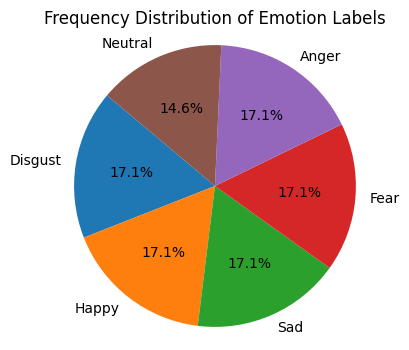

In [7]:
label_counts = df['label'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(4,4))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Frequency Distribution of Emotion Labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Let's display some random sample of the dataset and run it a couple of times to get a feeling for the audio and the emotional label.

In [8]:
# Selecting the random audio file
idx = np.random.randint(0, len(df))
sample = df.iloc[idx]
path = sample["file_path"]
label = sample["label"]

print(f"ID Location: {idx}")
print(f"Label: {label}")

# Load the audio file using torchaudio
speech, sr = torchaudio.load(path)

# Convert the loaded audio to numpy format and squeeze the dimensions
speech = speech[0].numpy().squeeze()

# Resample the audio to a standard rate of 16,000 Hz using librosa
speech = librosa.resample(speech, orig_sr=sr, target_sr=16000)

# Display the audio using IPython.display.Audio with autoplay enabled and the correct rate
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=16000)

ID Location: 5788

Label: Happy

In [53]:
# Selecting the random audio file
idx = np.random.randint(0, len(df))
sample = df.iloc[idx]
path = sample["file_path"]
label = sample["label"]

print(f"ID Location: {idx}")
print(f"Label: {label}")

ID Location: 7363

Label: Disgust

In [9]:
# Load the audio file using torchaudio
speech, sr = torchaudio.load(path)

# Convert the loaded audio to numpy format and squeeze the dimensions
speech = speech[0].numpy().squeeze()

# Resample the audio to a standard rate of 16,000 Hz using librosa
speech = librosa.resample(speech, orig_sr=sr, target_sr=32000)

# Display the audio using IPython.display.Audio with autoplay enabled and the correct rate
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=32000)

For training purposes, we need to split data into train test sets; in this specific example, we break with a `20%` rate for the test set.

In [61]:
save_path = "Final_data"

# Separating the data into trainign and testing data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["label"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)

print(train_df.shape)
print(test_df.shape)

(5953, 2)

(1489, 2)

## Prepare Data for Training

In [2]:
# Define the paths to the train and validation CSV files
data_files = {
    "train": "Final_data/train.csv",
    "validation": "Final_data/test.csv",
}

# Load the datasets from the CSV files using the specified delimiter
dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

# Extract the train and validation datasets
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

# Print the train and validation datasets for verification
print(train_dataset)
print(eval_dataset)

Dataset({
    features: ['file_path', 'label'],
    num_rows: 5953
})

Dataset({
    features: ['file_path', 'label'],
    num_rows: 1489
})

In [3]:
# We need to specify the input and output column
input_column = "file_path"
target_column = "label"

# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(target_column)

# Let's sort it for determinism
label_list.sort()  
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 6 classes: ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']

### Important Note
The goal is to preprocess audio data to make it suitable for input into a classification model.Wav2Vec2 is a model architecture designed to process raw audio waveforms. It converts these waveforms into meaningful representations that can be used for downstream tasks such as classification, speech recognition, or translation.

#### Handling Audio Representations:

Audio data is generally long and complex, and Wav2Vec2 outputs a 3D representation of the input audio. These dimensions typically consist of:

- The number of audio frames (sequence length).
- The batch size (number of audio samples being processed simultaneously).
- The feature dimension (the depth of the representation, i.e., how rich or detailed the features are).
Since many models prefer 2D representations (batch size and feature dimension), a merge strategy (pooling mode) is required to reduce the sequence length dimension, i.e., condensing the time information of audio into a single set of features.

#### Merge Strategy (Pooling Mode):

There are different ways to reduce the dimensionality:

- Mean pooling: Takes the average value of the features over time, which often smooths the data.
- Sum pooling: Sums the values over the time dimension.
- Max pooling: Takes the maximum value of the features over time, focusing on the most dominant features.
In this specific task, the mean pooling strategy was found to perform better, likely because averaging can provide a more balanced representation of the entire audio clip.

In [4]:
from transformers import Wav2Vec2Config,Wav2Vec2Model,Wav2Vec2Processor

def load_wav2vec2_model(model_name='facebook/wav2vec2-base-960h'):
    """
    Loads a pre-trained Wav2Vec2 model with its configuration and feature extractor.

    Args:
        model_name (str, optional): The name of the pre-trained model to load. Defaults to 'facebook/wav2vec2-base-960h'.

    Returns:
        Wav2Vec2Model: The loaded pre-trained Wav2Vec2 model.
    """
    # Loading the configuration, feature extractor and the pretrained model
    config = Wav2Vec2Config.from_pretrained(model_name)
    setattr(config, 'pooling_mode', "mean")
    processor = Wav2Vec2Processor.from_pretrained(model_name)
    model = Wav2Vec2Model.from_pretrained(model_name, config=config)

    return model,processor,config

pt_model,processor,config = load_wav2vec2_model('facebook/wav2vec2-base-960h')

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Preprocess Data

So far, we downloaded, loaded, and split the SER dataset into train and test sets. The instantiated our strategy configuration for using context representations in our classification problem SER. Now, we need to extract features from the audio path in context representation tensors and feed them into our classification model to determine the emotion in the speech.

Since the audio file is saved in the `.wav` format, it is easy to use **[Librosa](https://librosa.org/doc/latest/index.html)** or others, but we suppose that the format may be in the `.mp3` format in case of generality. We found that the **[Torchaudio](https://pytorch.org/audio/stable/index.html)** library works best for reading in `.mp3` data.

An audio file usually stores both its values and the sampling rate with which the speech signal was digitalized. We want to store both in the dataset and write a **map(...)** function accordingly. Also, we need to handle the string labels into integers for our specific classification task in this case, the **single-label classification** you may want to use for your **regression** or even **multi-label classification**.

In [5]:
def speech_file_to_array_fn(path):
    """
    Loads an audio file from the given path, resamples it to 16kHz, and returns the audio array.
    
    Args:
    - path (str): The path to the audio file.
    
    Returns:
    - speech (numpy array): The resampled audio array.
    """
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, 16000)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

def label_to_id(label, label_list):
    """
    Converts a label string to its corresponding index in the label list.
    
    Args:
    - label (str): The label string to convert.
    - label_list (list): The list of labels.
    
    Returns:
    - int: The index of the label in the label list, or -1 if not found.
    """
    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1
    return label

def preprocess_function(examples):
    """
    Preprocesses a batch of examples by converting audio files to arrays and labels to IDs.
    
    Args:
    - examples (dict): A batch of examples containing 'file_path' and 'label'.
    
    Returns:
    - result (dict): A dictionary containing the preprocessed audio arrays and label IDs.
    """
    speech_list = [speech_file_to_array_fn(path) for path in examples['file_path']]
    target_list = [label_to_id(label, label_list) for label in examples['label']]
    result = processor(speech_list, sampling_rate=16000)
    result["labels"] = list(target_list)
    return result

# Now, apply the mapping (you can start with num_proc=1 to debug first)
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=1  # Use 1 for now and then scale up after debugging
)
eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=1
)

In [6]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


In [7]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


## Training

The data is processed so that we are ready to start setting up the training pipeline. We will make use of 🤗's [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, XLSR-Wav2Vec2 has a much larger input length than output length. *E.g.*, a sample of input length 50000 has an output length of no more than 100. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, fine-tuning XLSR-Wav2Vec2 requires a special padding data collator, which we will define below

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to correctly transcribe speech.

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

Without going into too many details, in contrast to the common data collators, this data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them (again making use of XLSR-Wav2Vec2's context manager). This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are **not** taken into account when computing the loss.

In [8]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2Processor


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [9]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, the evaluation metric is defined. There are many pre-defined metrics for classification/regression problems, but in this case, we would continue with just **Accuracy** for classification and **MSE** for regression. You can define other metrics on your own.

In [10]:
is_regression = False

In [11]:
import numpy as np
from transformers import EvalPrediction


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

Now, we can load the pretrained XLSR-Wav2Vec2 checkpoint into our classification model with a pooling strategy.

In [12]:
model = Wav2Vec2ForSpeechClassification.from_pretrained(
    "facebook/wav2vec2-base-960h",
    config=config,
)

Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The first component of XLSR-Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretraining and as stated in the [paper](https://arxiv.org/pdf/2006.13979.pdf) does not need to be fine-tuned anymore.
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [13]:
model.freeze_feature_extractor()

In a final step, we define all parameters related to training.
To give more explanation on some of the parameters:
- `learning_rate` and `weight_decay` were heuristically tuned until fine-tuning has become stable. Note that those parameters strongly depend on the Common Voice dataset and might be suboptimal for other speech datasets.

For more explanations on other parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

**Note**: If one wants to save the trained models in his/her google drive the commented-out `output_dir` can be used instead.

In [14]:
# from google.colab import drive

# drive.mount('/gdrive')

In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="artifacts/wav2vec2-xlsr-greek-speech-emotion-recognition",
    # output_dir="/content/gdrive/MyDrive/wav2vec2-xlsr-greek-speech-emotion-recognition"
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    num_train_epochs=1.0,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=1e-4,
    save_total_limit=2,
)

c:\Users\yuvraj.s_maxval\Desktop\F_Projects\VocalEmotion-AI\.venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>={ACCELERATE_MIN_VERSION}'`

For future use we can create our training script, we do it in a simple way. You can add more on you own.

In [ ]:
from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)

if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast


class CTCTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        """
        Perform a training step on a batch of inputs.

        Subclass and override to inject custom behavior.

        Args:
            model (:obj:`nn.Module`):
                The model to train.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.

                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument :obj:`labels`. Check your model's documentation for all accepted arguments.

        Return:
            :obj:`torch.Tensor`: The tensor with training loss on this batch.
        """

        model.train()
        inputs = self._prepare_inputs(inputs)

        if self.use_amp:
            with autocast():
                loss = self.compute_loss(model, inputs)
        else:
            loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        if self.use_amp:
            self.scaler.scale(loss).backward()
        elif self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.deepspeed:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()


Now, all instances can be passed to Trainer and we are ready to start training!

In [ ]:
trainer = CTCTrainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.feature_extractor,
)

### Training

Training will take between 10 and 60 minutes depending on the GPU allocated to this notebook.

In case you want to use this google colab to fine-tune your model, you should make sure that your training doesn't stop due to inactivity. A simple hack to prevent this is to paste the following code into the console of this tab (right mouse click -> inspect -> Console tab and insert code).

```javascript
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);
```

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
10,1.531200,1.542005,0.280992
20,1.545000,1.437195,0.388430
30,1.519600,1.392583,0.396694
40,1.425600,1.290362,0.429752
50,1.408200,1.239589,0.438017
60,1.287800,1.215581,0.487603


TrainOutput(global_step=60, training_loss=1.4529215176900228, metrics={'train_runtime': 594.5685, 'train_samples_per_second': 0.812, 'train_steps_per_second': 0.101, 'total_flos': 8.45847594771822e+16, 'epoch': 0.99})

The training loss goes down and we can see that the Acurracy on the test set also improves nicely. Because this notebook is just for demonstration purposes, we can stop here.

The resulting model of this notebook has been saved to [m3hrdadfi/wav2vec2-xlsr-greek-speech-emotion-recognition](https://huggingface.co/m3hrdadfi/wav2vec2-xlsr-greek-speech-emotion-recognition)

As a final check, let's load the model and verify that it indeed has learned to recognize the emotion in the speech.

Let's first load the pretrained checkpoint.

## Evaluation

In [ ]:
import librosa
from sklearn.metrics import classification_report

In [ ]:
test_dataset = load_dataset("csv", data_files={"test": "/content/data/test.csv"}, delimiter="\t")["test"]
test_dataset

Using custom data configuration default-557d7b43c54d3362


Dataset csv downloaded and prepared to /content/cache/csv/default-557d7b43c54d3362/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 121
})

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
model_name_or_path = "m3hrdadfi/wav2vec2-xlsr-greek-speech-emotion-recognition"
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

In [ ]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)

    batch["speech"] = speech_array
    return batch


def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [ ]:
test_dataset = test_dataset.map(speech_file_to_array_fn)

In [ ]:
result = test_dataset.map(predict, batched=True, batch_size=8)

In [ ]:
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

['anger', 'disgust', 'fear', 'happiness', 'sadness']

In [ ]:
y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]

print(y_true[:5])
print(y_pred[:5])

[1, 4, 0, 4, 3]
[1, 4, 0, 4, 3]


In [ ]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

       anger       0.96      0.96      0.96        24
     disgust       0.96      1.00      0.98        24
        fear       0.96      0.96      0.96        24
   happiness       1.00      0.88      0.93        24
     sadness       0.93      1.00      0.96        25

    accuracy                           0.96       121
   macro avg       0.96      0.96      0.96       121
weighted avg       0.96      0.96      0.96       121



# Prediction

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, Wav2Vec2Processor

import librosa
import IPython.display as ipd
import numpy as np
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name_or_path = "m3hrdadfi/wav2vec2-xlsr-greek-speech-emotion-recognition"
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
sampling_rate = processor.feature_extractor.sampling_rate
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

In [ ]:
def speech_file_to_array_fn(path, sampling_rate):
    speech_array, _sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech


def predict(path, sampling_rate):
    speech = speech_file_to_array_fn(path, sampling_rate)
    features = processor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits

    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    outputs = [{"Emotion": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return outputs


STYLES = """
<style>
div.display_data {
    margin: 0 auto;
    max-width: 500px;
}
table.xxx {
    margin: 50px !important;
    float: right !important;
    clear: both !important;
}
table.xxx td {
    min-width: 300px !important;
    text-align: center !important;
}
</style>
""".strip()

def prediction(df_row):
    path, emotion = df_row["path"], df_row["emotion"]
    df = pd.DataFrame([{"Emotion": emotion, "Sentence": "    "}])
    setup = {
        'border': 2,
        'show_dimensions': True,
        'justify': 'center',
        'classes': 'xxx',
        'escape': False,
    }
    ipd.display(ipd.HTML(STYLES + df.to_html(**setup) + "<br />"))
    speech, sr = torchaudio.load(path)
    speech = speech[0].numpy().squeeze()
    speech = librosa.resample(np.asarray(speech), sr, sampling_rate)
    ipd.display(ipd.Audio(data=np.asarray(speech), autoplay=True, rate=sampling_rate))

    outputs = predict(path, sampling_rate)
    r = pd.DataFrame(outputs)
    ipd.display(ipd.HTML(STYLES + r.to_html(**setup) + "<br />"))

In [ ]:
test = pd.read_csv("/content/data/test.csv", sep="\t")
test.head()

,name,path,emotion
0,d09 (5),/content/data/aesdd/disgust/d09 (5).wav,disgust
1,s20 (2),/content/data/aesdd/sadness/s20 (2).wav,sadness
2,a17 (5),/content/data/aesdd/anger/a17 (5).wav,anger
3,s16 (6),/content/data/aesdd/sadness/s16 (6).wav,sadness
4,h14 (4),/content/data/aesdd/happiness/h14 (4).wav,happiness


In [ ]:
prediction(test.iloc[0])

,Emotion,Sentence
0,disgust,


,Emotion,Score
0,anger,0.0%
1,disgust,99.4%
2,fear,0.1%
3,happiness,0.1%
4,sadness,0.4%


In [ ]:
prediction(test.iloc[1])

,Emotion,Sentence
0,sadness,


,Emotion,Score
0,anger,0.5%
1,disgust,0.2%
2,fear,0.1%
3,happiness,0.0%
4,sadness,99.2%


In [ ]:
prediction(test.iloc[2])

,Emotion,Sentence
0,anger,


,Emotion,Score
0,anger,99.4%
1,disgust,0.0%
2,fear,0.1%
3,happiness,0.2%
4,sadness,0.2%
